# RSNA-MICCAI Kaggle Competition

The objective of this project is to predict the likelihood of MGMT promoter methylation given four types of structural multi-parametric MRI scans: 
- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)

This is useful for predicing receptiveness to chemotherapy because the MGMT promoter fights against the agents used in chemotherapy.  When the MGMT promoter is methylated, the promoter is disabled, thereby making that system receptive to chemotherapy.

# Let's First Explore the Data

In [1]:
# Importing relevant packages for EDA
import os
import math
from typing import List
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from PIL import Image


## What is the Output?

As said in the introduction, the goal of our model is to predict the probability of methylation.  In the sample submission below, there is a list of BraTS2IDs with corresponding probabilities of 0.5 each.

In [2]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head(10)

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
5,47,0.5
6,79,0.5
7,80,0.5
8,82,0.5
9,91,0.5


When training, we'll be given binary labels for the presence of MGMT promoter methylation.

In [3]:
train_labels = pd.read_csv("data/train_labels.csv")
print(f"{train_labels.shape[0] = }")
train_labels.head(10)

train_labels.shape[0] = 582


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


Let's look at the breakdown of patients with and without MGMT promoter methylation.

In [4]:
with_methylation = (train_labels["MGMT_value"] == 1).sum()
without_methylation = train_labels.shape[0] - with_methylation
print(f"{with_methylation = }")
print(f"{without_methylation = }")


with_methylation = 306
without_methylation = 276


## What is the Input?

For each patient (who has an ID), we have four different types of multi-paramteric MRI scans.  Each MRI scan is a 3D scan broken down into a folder of 2D images.  To start, let's take a look at one image from one of the FLAIR training scans. 

Number of FLAIR Images = 288
Number of T1w Images = 29
Number of T1wCE Images = 86
Number of T2w Images = 274


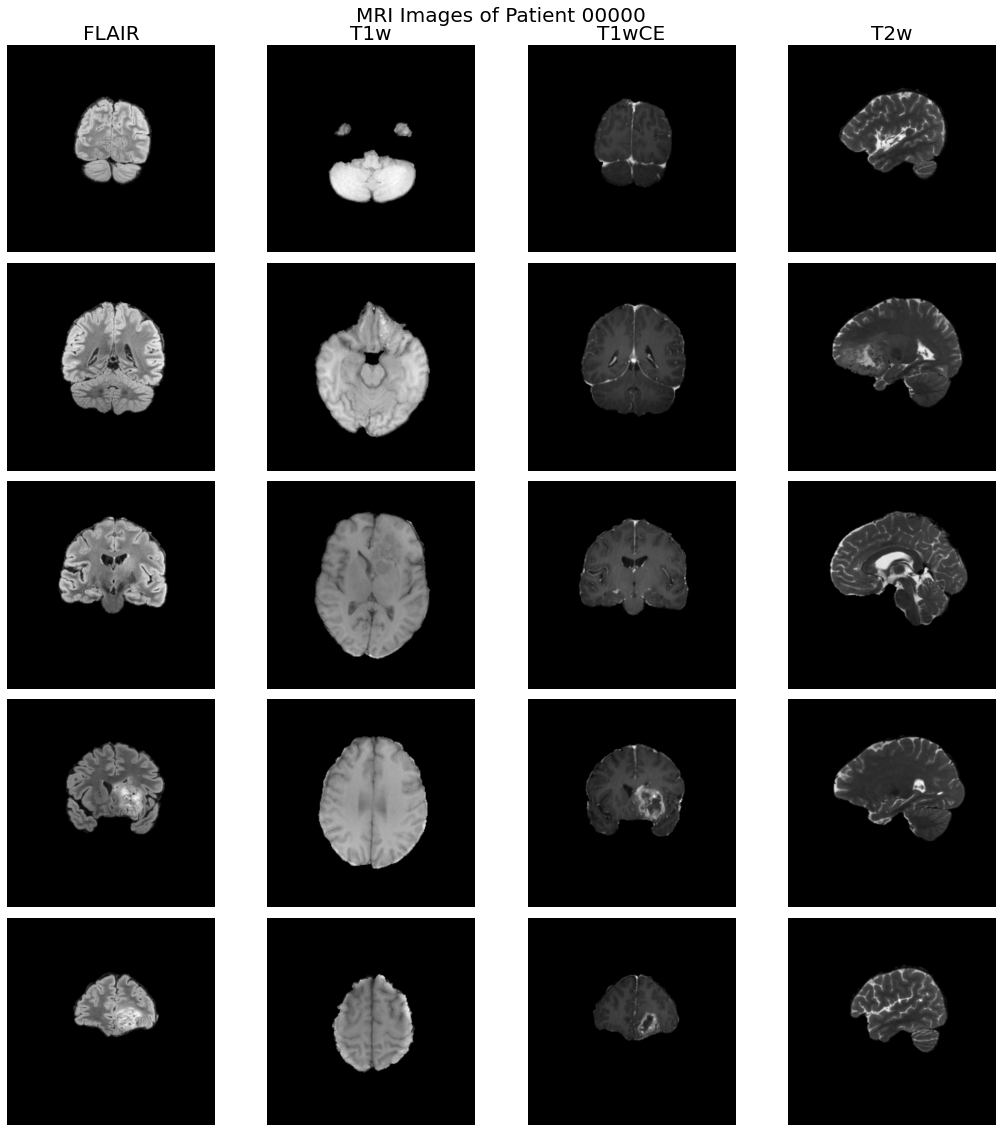

In [9]:
patient_path = "data/train/00000/"
mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
num_splits = 5
splits = [x/(num_splits + 1) for x in range(1, num_splits + 1)]

fig, ax = plt.subplots(num_splits, 4, figsize=(16, 16), tight_layout=True)
for i, mri_type in enumerate(mri_types):
    filenames = os.listdir(os.path.join(patient_path, mri_type))
    filenames.sort(
        key=lambda key: [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', key)])

    print(f"Number of {mri_type} Images = {len(filenames)}")
    for j, quartile in enumerate(splits):
        filename = filenames[math.floor(len(filenames)*quartile)]

        example_image = Image.open(
            os.path.join(patient_path, mri_type, filename))

        ax[j, i].imshow(example_image, cmap="gray")
        ax[j, i].set_axis_off()
        if not j:
            ax[j, i].set_title(mri_type, size=20)

fig.suptitle("MRI Images of Patient 00000", size=20)
fig.show()


## Data Management

Let's add folder names to each row of the training labels.

In [11]:
train_labels["imfolder"] = ["{0:05d}".format(
    id) for id in train_labels["BraTS21ID"]]
train_labels.head(10)


,BraTS21ID,MGMT_value,imfolder
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006
5,8,1,00008
6,9,0,00009
7,11,1,00011
8,12,1,00012
9,14,1,00014


Let's add the number of MRI scans of each type for each patient.

In [12]:
train_path = "data/train"
train_labels = train_labels.reindex(
    columns=train_labels.columns.tolist() + mri_types, fill_value=0)
train_labels[mri_types] = train_labels[mri_types].astype(int)

for i in train_labels.index:
    for mri_type in mri_types:
        train_labels.at[i, mri_type] = sum(len(files) for _, _, files in os.walk(
            os.path.join(train_path, train_labels.at[i, "imfolder"], mri_type)))

train_labels.head(10)


,BraTS21ID,MGMT_value,imfolder,FLAIR,T1w,T1wCE,T2w
0,0,1,00000,288,29,86,274
1,2,1,00002,67,27,88,269
2,3,0,00003,71,28,88,285
3,5,1,00005,277,26,83,272
4,6,1,00006,68,28,89,270
5,8,1,00008,143,26,134,143
6,9,0,00009,195,27,278,200
7,11,1,00011,72,29,84,72
8,12,1,00012,300,28,235,364
9,14,1,00014,146,208,208,64


Unfortunately, it looks like the number of MRI images is not consistent across patients and MRI types.  Let's see how many patients have the same number of images across MRI types.

In [13]:
num_allsame = sum([train_labels.at[i, "FLAIR"] == train_labels.at[i, "T1w"]
                   == train_labels.at[i, "T1wCE"] == train_labels.at[i, "T2w"]
                   for i in train_labels.index])
print(f"{num_allsame = }")


num_allsame = 32


Based on these observations, it looks like we can't use a standard 3D ConvNet; rather, it would have to be a 2.5D ConvNet.  We can also try video classification with a 2D CNN/RNN combination.

# Preprocessing and Splitting Data

Let's split the folder data into features/targets and set up a KFold cross-validation object.

In [14]:
# Establish hyperparameters pertaining to KFold
N_SPLITS = 5
RANDOM_STATE = 97

In [15]:
features = train_labels["imfolder"].to_numpy(dtype=str)
targets = train_labels["MGMT_value"].to_numpy(dtype=np.float32)
k_fold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)


# Video Classification Approach

In [16]:
# Import relevant packages for video classification
import time
import gc

import torch
from torch.nn import BCELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from src import video_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device = }")

#import importlib
#importlib.reload(video_model)

device = device(type='cuda')


Let's begin with the video classification approach by thinking about what shape we want our data to be in.  For every scan of a particular patient we want to process the entire sequence of images.  So, this would leave us with data of shape ```(num_images, 1, 224, 224)```.  As we saw in the EDA, the number of images is not constant across patient nor scan type, so ```num_images``` is variable.  In [src/video_model.py](src/video_model.py) you'll find the datset we use to create this shape.

In [17]:
# Establish hyperparameters pertaining to the datasets
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 1
DIRECTORY = "data/train/"

In [18]:
video_training_dataset = video_model.VideoMRIDataset(
    file_data=features, class_data=targets, directory=DIRECTORY, image_size=IMAGE_SIZE)

example_sample, _ = video_training_dataset[17]
print(f"Patient id = {features[17]}")
print(
    f"Data shapes = { {mri_type: video.size() for mri_type, video in example_sample.items()} }")


Patient id = 00025
Data shapes = {'FLAIR': torch.Size([69, 3, 224, 224]), 'T1w': torch.Size([28, 3, 224, 224]), 'T1wCE': torch.Size([72, 3, 224, 224]), 'T2w': torch.Size([69, 3, 224, 224])}


Now that we've seen some an example dataset, let's actually create a function to create the train and valid dataloaders given some data (which will be split in K-Fold cross validation).

In [19]:
def video_create_dataloaders(train_features, train_targets, valid_features, valid_targets):
    # Train data
    video_train_dataset = video_model.VideoMRIDataset(
        file_data=train_features, class_data=train_targets, directory=DIRECTORY, image_size=IMAGE_SIZE)
    video_train_dataloader = DataLoader(
        video_train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

    # valid data
    video_valid_dataset = video_model.VideoMRIDataset(
        file_data=valid_features, class_data=valid_targets, directory=DIRECTORY, image_size=IMAGE_SIZE)
    video_valid_dataloader = DataLoader(
        video_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)

    return video_train_dataloader, video_valid_dataloader


Let's now create function to train and evaluate the model.

In [20]:
# Train and Evaluate
def train_function(model, train_dataloader, optimizer, criterion, learning_rate, epoch, device):
    model.train()
    total_loss = 0.
    start_time = time.time()
    log_interval = len(train_dataloader)//10

    for batch_num, (scans, class_num) in enumerate(train_dataloader):
        for mri_type, scan in scans.items():
            scans[mri_type] = scan.to(device)
        class_num = class_num.to(device)

        optimizer.zero_grad()
        output = model(scans)

        loss = criterion(output, class_num)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        if batch_num % log_interval == 0 and batch_num > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:03.3f} | ms/batch {:5.2f} | '
                  'loss {:5.5f}'.format(
                      epoch, batch_num, len(
                          train_dataloader.dataset) // train_dataloader.batch_size,
                      learning_rate, elapsed * 1000 / log_interval,
                      cur_loss))
            total_loss = 0.
            start_time = time.time()


def evaluate(eval_model, valid_dataloader, criterion, device):
    eval_model.eval()
    num_correct = 0
    total_loss = 0.

    with torch.no_grad():
        for scans, class_num in valid_dataloader:
            for mri_type, scan in scans.items():
                scans[mri_type] = scan.to(device)
            class_num = class_num.to(device)

            output = eval_model(scans)
            loss = criterion(output, class_num)

            total_loss += loss.item()
            num_correct += torch.sum(torch.eq(torch.round(output), class_num))

    return num_correct / len(valid_dataloader.dataset), total_loss/len(valid_dataloader)


We'll also need to make a funciton for the overall training process, as we are conducting k-fold cross-validation.

In [21]:
# Establish hyperparamters pertaining to the training of the model
EPOCHS = 10
LEARNING_RATE = 0.001
LSTM_UNITS = 256


In [22]:
# Function to run through training process
def training_process(epochs, train_dataloader, valid_dataloader, device, learning_rate):
    model = video_model.VideoMRIEnsemble(
        mri_types, LSTM_UNITS).to(device)
    criterion = BCELoss()
    optimizer = Adam(model.parameters(), LEARNING_RATE)

    best_accuracy = 0.
    best_model = None
    accuracy_list, valid_loss_list = [], []

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_function(model, train_dataloader, optimizer,
                       criterion, learning_rate, epoch, device)
        accuracy, loss = evaluate(model, valid_dataloader, criterion, device)
        print('-'*89)
        print('| end of epoch {:3d}/{:3d} | time: {:5.2f}s | validation accuracy {:2.3f}% | '
              'valid loss {:5.5f}'.format(
                  epoch, EPOCHS, (time.time() - epoch_start_time), accuracy*100, loss))
        print('-'*89)

        accuracy_list.append(accuracy)
        valid_loss_list.append(loss)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    return best_model, accuracy_list, valid_loss_list


In each iteration our top level code will:
- Split thedata into train and valid indices
- Create the respective dataloaders
- train the model for ```EPOCHS``` number of epochs
- store a list of the validation accuracy and average validation loss 

In [ ]:
# Run through entire KFold process
gc.collect()
torch.cuda.empty_cache()

accuracy_list, valid_loss_list = [], []
for i, (train_indices, valid_indices) in enumerate(k_fold.split(features)):
    print('='*89)
    print(f"Fold {i+1}/{N_SPLITS}")
    print('='*89)

    train_features, valid_features = features[train_indices], features[valid_indices]
    train_targets, valid_targets = targets[train_indices], targets[valid_indices]

    video_train_dataloader, video_valid_dataloader = video_create_dataloaders(
        train_features, train_targets, valid_features, valid_targets)

    _, accuracy_temp, valid_temp = training_process(
        EPOCHS, video_train_dataloader, video_valid_dataloader, device, LEARNING_RATE)
    accuracy_list.append(accuracy_temp)
    valid_loss_list.append(valid_temp)
